In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

100%|██████████| 42.0G/42.0G [06:08<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [ ]:
import pandas as pd
df = pd.read_csv("3/Data_Entry_2017.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Load metadata
metadata_path = "3/Data_Entry_2017.csv"  # Update with the correct path
all_images_path = "allimages"  # Update with the correct folder path

df = pd.read_csv(metadata_path)

# One-hot encode multilabels
all_labels = sorted(df["Finding Labels"].str.split('|').explode().unique())  # Sort for consistent mapping
label_mapping = {label: i for i, label in enumerate(all_labels)}

# Create multilabel one-hot encoding
def create_label_vector(labels):
    vector = np.zeros(len(all_labels), dtype="float32")
    for label in labels.split('|'):
        vector[label_mapping[label]] = 1.0
    return vector

df["Label Vector"] = df["Finding Labels"].apply(create_label_vector)

# Filter 1000 random images for testing purposes
# df_sample = df.sample(5000, random_state=42)
df["Image Path"] = df["Image Index"].apply(lambda x: os.path.join(all_images_path, x))

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.utils import Sequence

# Custom data generator class
class DataGenerator(Sequence):
    def __init__(self, df, image_dir, batch_size=32, image_size=(224, 224)):
        self.df = df
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(df))  # Create indices for batching

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        # Get the indices for the batch
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Get the image paths and labels for this batch
        batch_image_paths = self.df["Image Path"].iloc[batch_indexes].values
        batch_labels = np.array(self.df["Label Vector"].iloc[batch_indexes].tolist(), dtype=np.float32)

        # Load and preprocess the images
        images = np.array([self._load_and_preprocess_image(image_path) for image_path in batch_image_paths])

        return images, batch_labels

    def _load_and_preprocess_image(self, image_path):
        # Read image file
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB
        image = tf.image.resize(image, self.image_size)  # Resize image
        image = image / 255.0  # Normalize image
        return image

    def on_epoch_end(self):
        # Optionally shuffle data at the end of each epoch
        np.random.shuffle(self.indexes)


# Instantiate the generator for training and testing
train_gen = DataGenerator(train_df, all_images_path, batch_size=32)
test_gen = DataGenerator(test_df, all_images_path, batch_size=32)

In [ ]:
# Load VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

In [ ]:
# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(all_labels), activation='sigmoid')(x)  # Multilabel output

model = Model(inputs=base_model.input, outputs=output)

# Compile the model with accuracy as a metric
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
# history = model.fit(
#     train_images, train_labels,
#     validation_data=(test_images, test_labels),
#     epochs=20,
#     batch_size=32,
#     callbacks=[lr_scheduler]
# )

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,
    batch_size=32,
    callbacks=[lr_scheduler]
)

Epoch 1/20
2803/2803 [==============================] - 2566s 915ms/step - loss: 0.2365 - accuracy: 0.4831 - val_loss: 0.1957 - val_accuracy: 0.5359 - lr: 1.0000e-04
Epoch 2/20
2803/2803 [==============================] - 2566s 915ms/step - loss: 0.2110 - accuracy: 0.5290 - val_loss: 0.1951 - val_accuracy: 0.5450 - lr: 1.0000e-04
Epoch 3/20
2803/2803 [==============================] - 2577s 919ms/step - loss: 0.2063 - accuracy: 0.5320 - val_loss: 0.1946 - val_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 4/20
2803/2803 [==============================] - 2580s 921ms/step - loss: 0.2035 - accuracy: 0.5340 - val_loss: 0.1923 - val_accuracy: 0.5457 - lr: 1.0000e-04
Epoch 5/20
2803/2803 [==============================] - 2571s 917ms/step - loss: 0.2016 - accuracy: 0.5353 - val_loss: 0.1921 - val_accuracy: 0.5421 - lr: 1.0000e-04
Epoch 6/20
2803/2803 [==============================] - 2567s 916ms/step - loss: 0.2002 - accuracy: 0.5351 - val_loss: 0.1906 - val_accuracy: 0.5453 - lr: 1.0000e-04
Epoc

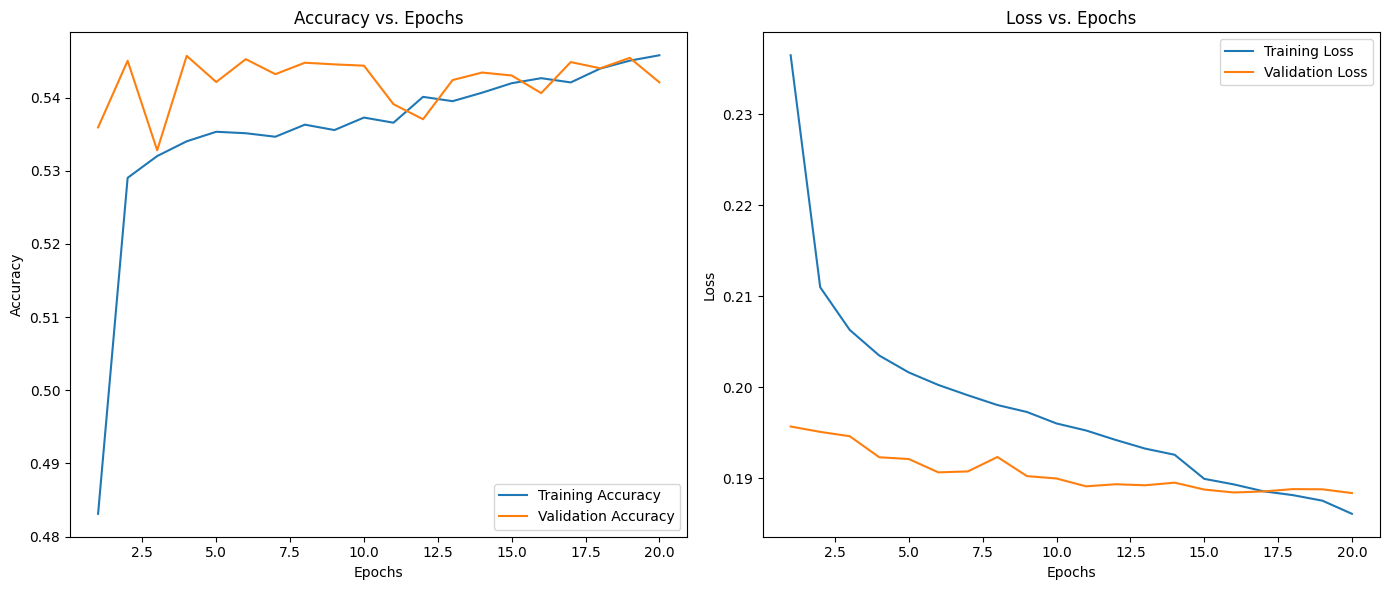

In [ ]:
import matplotlib.pyplot as plt


epochs = range(1, len(history.history['accuracy']) + 1)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy
axs[0].plot(epochs, train_accuracy, label='Training Accuracy')
axs[0].plot(epochs, val_accuracy, label='Validation Accuracy')
axs[0].set_title('Accuracy vs. Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_title('Loss vs. Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
model.save('chest_xray_VGG16_model.h5')  # Saves the model as a .h5 file

print("Model saved successfully!")